In [35]:
import re

from google.cloud import storage
from io import BytesIO

import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn import metrics

import category_encoders as ce

from xgboost import XGBRegressor

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from IPython.display import clear_output, display

In [2]:
mpl.style.use('bmh')

## Define Utility Functions

In [3]:
def retrieve_file(file_name, gs_bucket):
    blob = storage.Blob(file_name, gs_bucket)
    content = blob.download_as_string()
    return content

def display_description(field_name, description):
    print(re.search(re.escape(field_name) + r':.+\n\n(.+\n)+', description)[0])

def split_data_sequentially(data, test_size=0.1):
    test_length = int(len(data) * test_size)
    train = data[:-test_length].copy()
    test = data[-test_length:].copy()
    return train, test

def transform_dataset(df, **kwargs):
    if kwargs:
        features_missing_values = kwargs['features_missing_values']
        df.drop(features_missing_values, axis=1, inplace=True)
    
    for f in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        df[f].fillna('None', inplace=True)

    df.GarageYrBlt.fillna(0, inplace=True, downcast='infer')
    
    for f in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
        df[f].fillna('None', inplace=True)
    
    cat_features = df.dtypes[df.dtypes==np.dtype('O')].index.to_list()
    if kwargs:
        target_enc = kwargs['target_encoder']
        encoded_features = target_enc.transform(df[cat_features])
        df.loc[:, cat_features] = encoded_features
        median_values = kwargs['median_values']
        for f in df.columns:
            median_values[f] = df[f].median()
        df.fillna(median_values, inplace=True, downcast='infer')
    return df

## Ingest Data

In [4]:
client = storage.Client()

In [5]:
bucket = client.get_bucket('ames-house-dataset')

In [6]:
data = pd.read_csv(BytesIO(retrieve_file('train.csv', bucket)), index_col=0)

In [7]:
desc = retrieve_file('data_description.txt', bucket).decode('utf-8')

## Split Data

In [8]:
test_size = 0.2
random_seed = 42
train, valid = model_selection.train_test_split(data, test_size=test_size, random_state=random_seed)
train = train.copy()
valid = valid.copy()

## Identify Features With Missing Values

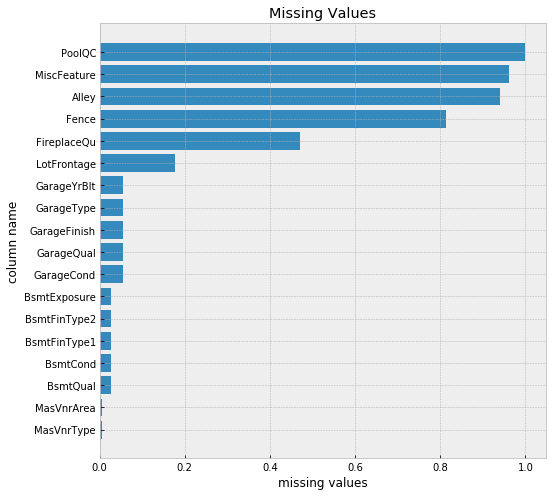

In [9]:
fig = plt.figure(figsize=(8, 8))
missing_values = train.isna().sum() / len(train)
to_plot = missing_values[missing_values > 0].sort_values()
plt.barh(to_plot.index, to_plot.values)
plt.xlabel('missing values')
plt.ylabel('column name')
plt.title('Missing Values')
plt.show()

In [10]:
display_description('LotFrontage', desc)

LotFrontage: Linear feet of street connected to property

LotArea: Lot size in square feet



We can drop all features where more than 40% of the information is missing.

In [11]:
features_missing_values = missing_values[missing_values>0.4].index.to_list()

In [12]:
train.drop(features_missing_values, axis=1, inplace=True)
missing_values = train.isna().sum() / len(train)

An interesting fact to notice is that all garage-related fields have the same number of missing values. This could indicate that houses where those features have missing values do not have garage.

In [13]:
missing_values[missing_values.index.str.match(r'^Garage') % missing_values>0]

GarageType      0.055651
GarageYrBlt     0.055651
GarageFinish    0.055651
GarageQual      0.055651
GarageCond      0.055651
dtype: float64

In [14]:
for f in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    train[f].fillna('None', inplace=True)

train.GarageYrBlt.fillna(0, inplace=True, downcast='infer')
missing_values = train.isna().sum() / len(train)

We can observe the same for basement.

In [15]:
missing_values[missing_values.index.str.match(r'^Bsmt') % missing_values>0]

BsmtQual        0.026541
BsmtCond        0.026541
BsmtExposure    0.027397
BsmtFinType1    0.026541
BsmtFinType2    0.027397
dtype: float64

In [16]:
for f in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    train[f].fillna('None', inplace=True)

missing_values = train.isna().sum() / len(train)

In the case of the `MasVnrType`, `MasVnrArea` and `Electrical`, there is alreade a `None` value, so missing might mean something else. The sum of all rows where those features have missing values is less than 10, so we can just drop them. However, if we deploy the model in production, missing value encountered during serving won't be handled. Therefore, we can set a strategy where:
* For numeric features, the median will be imputed;
* For categorical features, category boosing encoding will be applied. Subsequently, the median value of the transformed feature will be imputed;

## Add Feature Interactions

## Categorical Feature Encoding

In [17]:
cat_features = train.dtypes[train.dtypes==np.dtype('O')].index.to_list()

In [18]:
target_enc = ce.CatBoostEncoder(cols=cat_features)

In [19]:
target_enc.fit(train[cat_features], train.SalePrice)

CatBoostEncoder(a=1,
                cols=['MSZoning', 'Street', 'LotShape', 'LandContour',
                      'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                      'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                      'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                      'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
                      'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                      'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
                      'Electrical', 'KitchenQual', ...],
                drop_invariant=False, handle_missing='value',
                handle_unknown='value', random_state=None, return_df=True,
                sigma=None, verbose=0)

In [20]:
encoded_features = target_enc.transform(train[cat_features])
train.loc[:, cat_features] = encoded_features

## Impute Missing Values

In [21]:
median_values = dict()
for f in train.columns:
    median_values[f] = train[f].median()

In [22]:
train.fillna(median_values, inplace=True, downcast='infer')

## Take The LOG Of All Long Tail Distributions

## Select Best Features

## Train A Benchmark Model

In [23]:
params = {'features_missing_values': features_missing_values,
          'target_encoder': target_enc,
          'median_values': median_values}
valid = transform_dataset(valid, **params)

In [38]:
X_train = train.drop('SalePrice', axis=1)
y_train = train.SalePrice.values
X_valid = valid.drop('SalePrice', axis=1)
y_valid = valid.SalePrice.values

In [41]:
model = XGBRegressor(random_state=random_seed, objective='reg:squarederror')
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

In [42]:
r2_score = metrics.r2_score(y_valid, y_pred)
explained_variance = metrics.explained_variance_score(y_valid, y_pred)
mean_abs_error = metrics.mean_absolute_error(y_valid, y_pred)
max_error = metrics.max_error(y_valid, y_pred)

print(f'The r2 score is: {r2_score:.0%}')
print(f'The explained variance score is: {explained_variance:.0%}')
print(f'The mean absolute error is: {mean_abs_error:.0f}')
print(f'The maximal error is: {max_error:.0f}')

The r2 score is: 88%
The explained variance score is: 88%
The mean absolute error is: 17694
The maximal error is: 225604
